In [1]:
# The idea of this notebook is to keep track of averages, etc for some number of past windows (e.g. two past windows). We also
# keep track of peak information in EACH window. When there are no peaks in the most recent past window, then it should dominate
# the forecasting. When it has peaks, it must share forecasting with earlier windows, and so on.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

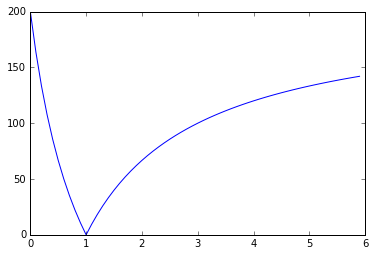

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [36]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# User should make sure windowSize * nWindows + peakShift doesn't exceed size of axis 1 for X (i.e. the width of X).

def window_features(X, windowSize = 64, nWindows = 2, peakShift = 30):
    Xheight, Xwidth = X.shape
    result = np.empty((Xheight,0))
    
    for i in range(nWindows):
        X_window = X[:, -(i+1) * windowSize -1: -i * windowSize - 1]
        newFeature = np.mean(X_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.std(X_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.dot(X_window, np.arange(windowSize)).reshape(-1,1)
        result = np.hstack((result, newFeature))
        
        peak_window = X_window - X[:, -(i+1) * windowSize - 1 - peakShift : -i * windowSize - 1 - peakShift]
        peak_window = np.abs(peak_window)
        newFeature = np.mean(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.mean(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        
        peak_window[peak_window > 0] = 1.0
        newFeature = np.sum(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        
    return result

In [37]:
# Look at shapes of feature functions.

windowCols = window_features(X_train)

print('X_train.shape = ', X_train.shape)
print('windowCols.shape = ', windowCols.shape)

X_train.shape =  (65118, 486)
windowCols.shape =  (65118, 12)


In [42]:
# Try a simple linear Regression.

model = Pipeline([ ('windows', FunctionTransformer(window_features)),
                   ('poly', PolynomialFeatures(2)),
                   ('linear', LinearRegression()) ])
score = -cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
score = np.mean(score)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
test_score = smape(Y_predict, Y_test)
print('Cross validation score = ', score, '\tTest Score = ', test_score)

Cross validation score =  118.294621415 	Test Score =  119.858100298


In [ ]:
# Try a neural network.

model = Pipeline([ ('windows', FunctionTransformer(window_features)),
                   ('poly', PolynomialFeatures(2)),
                   ('neural', MLPRegressor(hidden_layer_sizes = (30, 10))) ])

score = -cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
score = np.mean(score)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
test_score = smape(Y_predict, Y_test)
print('Cross validation score = ', score, '\tTest Score = ', test_score)

C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
